In [7]:
%reset -f
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
import wandb


from customDatasets.audioDataset import AudioDataset


In [8]:
# free gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, input_size),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# test for deciding the mels parameters
from utils.audioUtils import AudioUtil
from torchaudio import transforms
import torch
audio_file = "./data/train/normal_id_00_00000000.wav"

aud = AudioUtil.open(audio_file)
sig, sr = aud
mel = transforms.MelSpectrogram(sr, n_fft=1000, hop_length=501, n_mels=128)
spec = mel(sig)
ampl = transforms.AmplitudeToDB(top_db=80)
spec = ampl(spec)


print(spec.shape)


torch.Size([1, 128, 320])


In [11]:
def train_model(model, train_dl, val_dl, test_dl, criterion, optimizer, device, wandb=None, epochs=5,step_size=5):
    lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    best_val_loss = np.inf
    for epoch in range(epochs):
        train_losses = []
        val_losses = []
        for inputs, labels in train_dl:
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(inputs.size(0), -1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        lr_scheduler.step()
        print(f'Epoch[{epoch + 1}/{epochs}], Train loss: {np.average(train_losses): .4f}')
        
        for inputs, labels in val_dl:
            model.eval()
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.shape[0]*inputs.shape[1], -1)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_losses.append(loss.item())
        print(f'Epoch[{epoch + 1}/{epochs}], Val loss: {np.average(val_losses): .4f}')
        if np.average(val_losses) < best_val_loss:
            best_val_loss = np.average(val_losses)
 
        full_scores = []
        full_labels = []
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(CONFIG["device"]), labels.to(CONFIG["device"])
            model.eval()
            with torch.no_grad():
                tmp_scores = []
                for idx in range (10):
                    outputs = model(inputs[:, idx, :, :])
                    mse = torch.sum((outputs - inputs[:, idx, :, :].view(inputs.size(0), -1)) ** 2, dim=1, keepdim=True) / outputs.shape[1]
                    tmp_scores.append(mse)

                scores = torch.cat(tmp_scores, dim=1)
                scores = torch.max(scores, dim=1).values

                full_scores.append(scores)
                full_labels.append(labels)
        
        full_labels = torch.cat([label for label in full_labels])
        full_scores = torch.cat([score for score in full_scores])
        fpr, tpr, _ = roc_curve(full_labels.cpu().detach(), full_scores.cpu().detach(), pos_label=0)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        if wandb:
            wandb.log({"roc_auc test": roc_auc, "val_loss": np.average(val_losses), "train_loss": np.average(train_losses)})
    return best_val_loss

In [12]:
def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

CONFIG = {
    "seed": 42,
    "epochs": 500,
    "num_classes": 2,
    "learning_rate": 0.001,
    "train_batch_size": 32,
    "val_batch_size": 16,
    "test_batch_size": 128,
    "criterion": nn.MSELoss(),
    "device":
        torch.device(
            "cuda:0" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )
}

set_seed(CONFIG['seed'])

data_path = "./data/train/"
data_path_test = "./data/test/"


meta_train_df = pd.read_csv("./data/train.csv")
meta_test_df = pd.read_csv("./data/test.csv")

train_df = meta_train_df[['filename', 'is_normal', 'machine_id']]
#range_train, range_test = train_test_split(range(len(train_df)), test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=meta_train_df['machine_id'])
#val_df = train_df.iloc[range_test].reset_index(drop=True)
# create an empty df
val_df = pd.DataFrame(columns=['filename', 'is_normal', 'machine_id'])
#train_df = train_df.iloc[range_train].reset_index(drop=True)
train_df = train_df
train_dataset = AudioDataset(train_df, data_path,in_memory=True, sgram_type="mel", augment=True, split_sgram=True)
val_dataset = AudioDataset(val_df, data_path,in_memory=True, sgram_type="mel", augment=False, test_mode=True)
test_df = meta_test_df[['filename', 'is_normal', 'machine_id']]
test_dataset = AudioDataset(test_df, data_path_test, in_memory=True, sgram_type="mel", augment=False, test_mode=True)

train_ds = train_dataset
val_ds = val_dataset
test_ds = test_dataset

train_dl = DataLoader(train_ds, batch_size=CONFIG['train_batch_size'], shuffle=True)
val_dl = DataLoader(val_ds, batch_size=CONFIG['val_batch_size'], shuffle=False)
test_dl = DataLoader(test_ds, batch_size=CONFIG["test_batch_size"], shuffle=False)

In [13]:
inputs, labels = next(iter(train_dl))

print(inputs.shape)

torch.Size([32, 1, 32, 128])


In [14]:
input_size = next(iter(train_dl))[0].shape[1] * next(iter(train_dl))[0].shape[2] * next(iter(train_dl))[0].shape[3]
model = Autoencoder(input_size, encoding_dim=128)
model = model.to(CONFIG["device"])
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)

In [15]:
# compute metrics
inputs_cat=[]
train_dataset.test_mode = True
for inputs, labels in train_dl:
    inputs_cat.append(inputs)
inputs_cat = torch.cat([input for input in inputs_cat])
inputs_cat = inputs_cat.view(-1,inputs_cat.shape[2],inputs_cat.shape[3])
print(inputs_cat.shape)
train_dataset.test_mode = False

torch.Size([23700, 32, 128])


In [16]:
mean = torch.mean(inputs_cat, dim=0)
std = torch.std(inputs_cat, dim=0)
print(mean.shape)
print(std.shape)
train_dataset.mean = mean
train_dataset.std = std
val_dataset.mean = mean
val_dataset.std = std
test_dataset.mean = mean
test_dataset.std = std

torch.Size([32, 128])
torch.Size([32, 128])


In [17]:
# init wandb
wandb.login()

wandb: Currently logged in as: micheleferrero9 (ai-ml-monitor). Use `wandb login --relogin` to force relogin


True

In [18]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Challenge_2_AETimeFrames",
)
# save all the parameters from the CONFIG dict
wandb.config.update(CONFIG)
print(wandb.config)

{'seed': 42, 'epochs': 500, 'num_classes': 2, 'learning_rate': 0.001, 'train_batch_size': 32, 'val_batch_size': 16, 'test_batch_size': 128, 'criterion': 'MSELoss()', 'device': 'cuda:0'}


In [19]:
training=True
input_size = next(iter(train_dl))[0].shape[1] * next(iter(train_dl))[0].shape[2] * next(iter(train_dl))[0].shape[3]
grid_search=False
measures=[1,0,1,1,1]
# testing emb space size
if training and grid_search :
    measures=[]
    for emb_space_size in [32, 64, 128, 256, 512]:
        model = Autoencoder(encoding_dim=emb_space_size, input_size=input_size)
        model = model.to(CONFIG["device"])
        optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
        measures.append(train_model(model, train_dl, val_dl, test_dl, CONFIG["criterion"], optimizer, CONFIG["device"], epochs=50))

In [20]:
if training:
    emb_spaces=[32, 64, 128, 256, 512]
    for emb_space_size, measure in zip(emb_spaces, measures):
        print(f"Emb space size: {emb_space_size}, Train loss: {measure}")
    print(f"Best emb space size: {emb_spaces[np.argmin([measure for measure in measures])]}")

Emb space size: 32, Train loss: 1
Emb space size: 64, Train loss: 0
Emb space size: 128, Train loss: 1
Emb space size: 256, Train loss: 1
Emb space size: 512, Train loss: 1
Best emb space size: 64


In [21]:
print(measures)

[1, 0, 1, 1, 1]


In [22]:
# take the best one and train it for more epochs
if training:
    emb_space_measures=[32, 64, 128, 256, 512]
    model = Autoencoder(encoding_dim=emb_space_measures[np.argmin([measure for measure in measures])], input_size=input_size)
    model = model.to(CONFIG["device"])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

In [23]:
training=True
if training:
    train_model(model, train_dl, val_dl, test_dl, CONFIG["criterion"], optimizer, CONFIG["device"], wandb, CONFIG["epochs"], 50)

Epoch[1/500], Train loss:  0.6520
Epoch[1/500], Val loss:  nan


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.7169787765293383


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[2/500], Train loss:  0.5683
Epoch[2/500], Val loss:  nan
0.7661589679567208


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[3/500], Train loss:  0.5353
Epoch[3/500], Val loss:  nan
0.7573824386183937


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[4/500], Train loss:  0.5353
Epoch[4/500], Val loss:  nan
0.7683853516437786


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[5/500], Train loss:  0.5242
Epoch[5/500], Val loss:  nan
0.7963587182688306


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[6/500], Train loss:  0.5001
Epoch[6/500], Val loss:  nan
0.7785434873075323


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[7/500], Train loss:  0.5045
Epoch[7/500], Val loss:  nan
0.7819184352892219


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[8/500], Train loss:  0.4886
Epoch[8/500], Val loss:  nan
0.7798293799417396


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[9/500], Train loss:  0.4824
Epoch[9/500], Val loss:  nan
0.7752392842280482


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[10/500], Train loss:  0.4775
Epoch[10/500], Val loss:  nan
0.7721057012068249


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[11/500], Train loss:  0.4699
Epoch[11/500], Val loss:  nan
0.7910070744902205


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[12/500], Train loss:  0.4700
Epoch[12/500], Val loss:  nan
0.7759092800665834


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[13/500], Train loss:  0.4640
Epoch[13/500], Val loss:  nan
0.7773283395755306


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[14/500], Train loss:  0.4572
Epoch[14/500], Val loss:  nan
0.7930794839783604


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[15/500], Train loss:  0.4592
Epoch[15/500], Val loss:  nan
0.7976071577195173


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[16/500], Train loss:  0.4611
Epoch[16/500], Val loss:  nan
0.7994007490636704


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[17/500], Train loss:  0.4475
Epoch[17/500], Val loss:  nan
0.786100707449022


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[18/500], Train loss:  0.4457
Epoch[18/500], Val loss:  nan
0.792313774448606


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[19/500], Train loss:  0.4468
Epoch[19/500], Val loss:  nan
0.7934124011652102


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[20/500], Train loss:  0.4497
Epoch[20/500], Val loss:  nan
0.7934373699542239


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[21/500], Train loss:  0.4609
Epoch[21/500], Val loss:  nan
0.790220557636288


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[22/500], Train loss:  0.4438
Epoch[22/500], Val loss:  nan
0.7966666666666666


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[23/500], Train loss:  0.4360
Epoch[23/500], Val loss:  nan
0.7985393258426966


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[24/500], Train loss:  0.4366
Epoch[24/500], Val loss:  nan
0.8178818143986682


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[25/500], Train loss:  0.4379
Epoch[25/500], Val loss:  nan
0.7951810237203496


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[26/500], Train loss:  0.4400
Epoch[26/500], Val loss:  nan
0.8162047440699126


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[27/500], Train loss:  0.4313
Epoch[27/500], Val loss:  nan
0.7995464003329171


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[28/500], Train loss:  0.4316
Epoch[28/500], Val loss:  nan
0.8065709529754472


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[29/500], Train loss:  0.4326
Epoch[29/500], Val loss:  nan
0.8123054515189347


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[30/500], Train loss:  0.4255
Epoch[30/500], Val loss:  nan
0.80541822721598


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[31/500], Train loss:  0.4301
Epoch[31/500], Val loss:  nan
0.7938743237619642


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[32/500], Train loss:  0.4228
Epoch[32/500], Val loss:  nan
0.7975364128173117


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[33/500], Train loss:  0.4297
Epoch[33/500], Val loss:  nan
0.8092675821889305


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[34/500], Train loss:  0.4282
Epoch[34/500], Val loss:  nan
0.8175530586766542


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[35/500], Train loss:  0.4252
Epoch[35/500], Val loss:  nan
0.8153058676654181


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[36/500], Train loss:  0.4228
Epoch[36/500], Val loss:  nan
0.8093466500208073


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[37/500], Train loss:  0.4248
Epoch[37/500], Val loss:  nan
0.8221889305035374


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[38/500], Train loss:  0.4244
Epoch[38/500], Val loss:  nan
0.7847732001664586


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[39/500], Train loss:  0.4226
Epoch[39/500], Val loss:  nan
0.8150062421972534


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[40/500], Train loss:  0.4214
Epoch[40/500], Val loss:  nan
0.7960216396171453


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[41/500], Train loss:  0.4200
Epoch[41/500], Val loss:  nan
0.8227132750728257


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[42/500], Train loss:  0.4185
Epoch[42/500], Val loss:  nan
0.8233333333333334


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[43/500], Train loss:  0.4153
Epoch[43/500], Val loss:  nan
0.8242779858510196


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[44/500], Train loss:  0.4178
Epoch[44/500], Val loss:  nan
0.818976279650437


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[45/500], Train loss:  0.4149
Epoch[45/500], Val loss:  nan
0.8216978776529338


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[46/500], Train loss:  0.4174
Epoch[46/500], Val loss:  nan
0.8125052018310445


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[47/500], Train loss:  0.4193
Epoch[47/500], Val loss:  nan
0.8143528922180607


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[48/500], Train loss:  0.4149
Epoch[48/500], Val loss:  nan
0.8251269246774866


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[49/500], Train loss:  0.4152
Epoch[49/500], Val loss:  nan
0.824207240948814


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[50/500], Train loss:  0.4210
Epoch[50/500], Val loss:  nan
0.8103454015813566


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[51/500], Train loss:  0.4070
Epoch[51/500], Val loss:  nan
0.8191801914273824


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[52/500], Train loss:  0.4041
Epoch[52/500], Val loss:  nan
0.8190803162713275


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[53/500], Train loss:  0.4026
Epoch[53/500], Val loss:  nan
0.8209737827715355


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[54/500], Train loss:  0.4095
Epoch[54/500], Val loss:  nan
0.831069496462755


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[55/500], Train loss:  0.4002
Epoch[55/500], Val loss:  nan
0.8274323761964211


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[56/500], Train loss:  0.4050
Epoch[56/500], Val loss:  nan
0.8273491468997087


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[57/500], Train loss:  0.4045
Epoch[57/500], Val loss:  nan
0.830374531835206


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[58/500], Train loss:  0.4151
Epoch[58/500], Val loss:  nan
0.8406408655846858


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[59/500], Train loss:  0.3995
Epoch[59/500], Val loss:  nan
0.8362630045776114


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[60/500], Train loss:  0.4016
Epoch[60/500], Val loss:  nan
0.830749063670412


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[61/500], Train loss:  0.4023
Epoch[61/500], Val loss:  nan
0.8234831460674158


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[62/500], Train loss:  0.4032
Epoch[62/500], Val loss:  nan
0.8262962962962963


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[63/500], Train loss:  0.4047
Epoch[63/500], Val loss:  nan
0.8215064502704952


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[64/500], Train loss:  0.4010
Epoch[64/500], Val loss:  nan
0.8266999583853516


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[65/500], Train loss:  0.4033
Epoch[65/500], Val loss:  nan
0.831839367457345


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[66/500], Train loss:  0.4001
Epoch[66/500], Val loss:  nan
0.8282438618393675


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[67/500], Train loss:  0.4003
Epoch[67/500], Val loss:  nan
0.8312817311693717


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[68/500], Train loss:  0.4017
Epoch[68/500], Val loss:  nan
0.8052517686225551


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[69/500], Train loss:  0.3936
Epoch[69/500], Val loss:  nan
0.8345568039950062


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[70/500], Train loss:  0.4025
Epoch[70/500], Val loss:  nan
0.8388597586350396


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[71/500], Train loss:  0.4005
Epoch[71/500], Val loss:  nan
0.8039741989180191


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[72/500], Train loss:  0.3978
Epoch[72/500], Val loss:  nan
0.8326674989596339


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[73/500], Train loss:  0.3950
Epoch[73/500], Val loss:  nan
0.8358302122347065


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[74/500], Train loss:  0.3915
Epoch[74/500], Val loss:  nan
0.8315563878485227


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[75/500], Train loss:  0.3981
Epoch[75/500], Val loss:  nan
0.838281315022888


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[76/500], Train loss:  0.4041
Epoch[76/500], Val loss:  nan
0.8115980024968789


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[77/500], Train loss:  0.3989
Epoch[77/500], Val loss:  nan
0.825076987099459


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[78/500], Train loss:  0.3919
Epoch[78/500], Val loss:  nan
0.8383895131086143


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[79/500], Train loss:  0.3958
Epoch[79/500], Val loss:  nan
0.8307032875572201


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[80/500], Train loss:  0.3947
Epoch[80/500], Val loss:  nan
0.8440740740740742


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[81/500], Train loss:  0.3958
Epoch[81/500], Val loss:  nan
0.8198751560549313


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[82/500], Train loss:  0.3925
Epoch[82/500], Val loss:  nan
0.8313712026633375


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[83/500], Train loss:  0.3964
Epoch[83/500], Val loss:  nan
0.8451727007906782


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[84/500], Train loss:  0.3946
Epoch[84/500], Val loss:  nan
0.8313150228880566


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[85/500], Train loss:  0.3946
Epoch[85/500], Val loss:  nan
0.8419725343320849


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[86/500], Train loss:  0.3902
Epoch[86/500], Val loss:  nan
0.8370411985018726


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[87/500], Train loss:  0.3949
Epoch[87/500], Val loss:  nan
0.8480524344569288


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[88/500], Train loss:  0.3970
Epoch[88/500], Val loss:  nan
0.8318352059925094


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[89/500], Train loss:  0.3895
Epoch[89/500], Val loss:  nan
0.8338035788597588


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[90/500], Train loss:  0.3965
Epoch[90/500], Val loss:  nan
0.8202621722846442


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[91/500], Train loss:  0.4060
Epoch[91/500], Val loss:  nan
0.8066479400749064


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[92/500], Train loss:  0.3942
Epoch[92/500], Val loss:  nan
0.8321681231793593


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[93/500], Train loss:  0.3913
Epoch[93/500], Val loss:  nan
0.8462838119017895


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[94/500], Train loss:  0.3950
Epoch[94/500], Val loss:  nan
0.8355555555555556


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[95/500], Train loss:  0.3912
Epoch[95/500], Val loss:  nan
0.8328297960882229


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[96/500], Train loss:  0.3882
Epoch[96/500], Val loss:  nan
0.8183562213899291


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[97/500], Train loss:  0.3987
Epoch[97/500], Val loss:  nan
0.8400790678318769


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[98/500], Train loss:  0.3933
Epoch[98/500], Val loss:  nan
0.8340907199334167


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[99/500], Train loss:  0.3927
Epoch[99/500], Val loss:  nan
0.8494631710362047


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[100/500], Train loss:  0.4034
Epoch[100/500], Val loss:  nan
0.810033291718685


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[101/500], Train loss:  0.3922
Epoch[101/500], Val loss:  nan
0.8370911360799002


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[102/500], Train loss:  0.3908
Epoch[102/500], Val loss:  nan
0.8305867665418227


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[103/500], Train loss:  0.3844
Epoch[103/500], Val loss:  nan
0.8460299625468166


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[104/500], Train loss:  0.3855
Epoch[104/500], Val loss:  nan
0.8425717852684145


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[105/500], Train loss:  0.3888
Epoch[105/500], Val loss:  nan
0.8322388680815647


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[106/500], Train loss:  0.3896
Epoch[106/500], Val loss:  nan
0.8478110694964628


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[107/500], Train loss:  0.3871
Epoch[107/500], Val loss:  nan
0.8476737411568873


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[108/500], Train loss:  0.3919
Epoch[108/500], Val loss:  nan
0.8448938826466916


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[109/500], Train loss:  0.3839
Epoch[109/500], Val loss:  nan
0.8401539741989179


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[110/500], Train loss:  0.3873
Epoch[110/500], Val loss:  nan
0.8184103204327923


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[111/500], Train loss:  0.3845
Epoch[111/500], Val loss:  nan
0.8348605909280067


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[112/500], Train loss:  0.3866
Epoch[112/500], Val loss:  nan
0.8489596337910943


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[113/500], Train loss:  0.3896
Epoch[113/500], Val loss:  nan
0.8137078651685392


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[114/500], Train loss:  0.3877
Epoch[114/500], Val loss:  nan
0.8484810653349979


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[115/500], Train loss:  0.3885
Epoch[115/500], Val loss:  nan
0.8447274240532667


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[116/500], Train loss:  0.3847
Epoch[116/500], Val loss:  nan
0.8505035372451104


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[117/500], Train loss:  0.3841
Epoch[117/500], Val loss:  nan
0.8437286724927173


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[118/500], Train loss:  0.3851
Epoch[118/500], Val loss:  nan
0.8496129837702872


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[119/500], Train loss:  0.3826
Epoch[119/500], Val loss:  nan
0.834569288389513


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[120/500], Train loss:  0.3845
Epoch[120/500], Val loss:  nan
0.8127174365376613


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[121/500], Train loss:  0.3890
Epoch[121/500], Val loss:  nan
0.8425842696629213


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[122/500], Train loss:  0.3859
Epoch[122/500], Val loss:  nan
0.8390137328339576


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[123/500], Train loss:  0.3841
Epoch[123/500], Val loss:  nan
0.8401081980857261


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[124/500], Train loss:  0.3907
Epoch[124/500], Val loss:  nan
0.8244028297960881


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[125/500], Train loss:  0.3854
Epoch[125/500], Val loss:  nan
0.8549729504785686


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[126/500], Train loss:  0.3796
Epoch[126/500], Val loss:  nan
0.8448064918851437


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[127/500], Train loss:  0.3950
Epoch[127/500], Val loss:  nan
0.8583770287141075


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[128/500], Train loss:  0.3864
Epoch[128/500], Val loss:  nan
0.8547149396587599


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[129/500], Train loss:  0.3835
Epoch[129/500], Val loss:  nan
0.834956304619226


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[130/500], Train loss:  0.3818
Epoch[130/500], Val loss:  nan
0.8439117769454849


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[131/500], Train loss:  0.3849
Epoch[131/500], Val loss:  nan
0.8374531835205993


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[132/500], Train loss:  0.3808
Epoch[132/500], Val loss:  nan
0.8383437369954225


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[133/500], Train loss:  0.3828
Epoch[133/500], Val loss:  nan
0.8273657927590511


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[134/500], Train loss:  0.3821
Epoch[134/500], Val loss:  nan
0.8483021223470661


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[135/500], Train loss:  0.3806
Epoch[135/500], Val loss:  nan
0.8465043695380774


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[136/500], Train loss:  0.4126
Epoch[136/500], Val loss:  nan
0.811190178942988


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[137/500], Train loss:  0.3814
Epoch[137/500], Val loss:  nan
0.8529379941739492


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[138/500], Train loss:  0.3824
Epoch[138/500], Val loss:  nan
0.8369662921348315


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[139/500], Train loss:  0.3885
Epoch[139/500], Val loss:  nan
0.8473741156887225


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[140/500], Train loss:  0.3839
Epoch[140/500], Val loss:  nan
0.8458843112775698


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[141/500], Train loss:  0.3855
Epoch[141/500], Val loss:  nan
0.8311194340407825


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[142/500], Train loss:  0.3857
Epoch[142/500], Val loss:  nan
0.8364835622138993


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[143/500], Train loss:  0.3845
Epoch[143/500], Val loss:  nan
0.842917186849771


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[144/500], Train loss:  0.3768
Epoch[144/500], Val loss:  nan
0.8336745734498543


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[145/500], Train loss:  0.3893
Epoch[145/500], Val loss:  nan
0.8219725343320848


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[146/500], Train loss:  0.3844
Epoch[146/500], Val loss:  nan
0.8514232209737828


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[147/500], Train loss:  0.3757
Epoch[147/500], Val loss:  nan
0.8317811069496462


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[148/500], Train loss:  0.3832
Epoch[148/500], Val loss:  nan
0.8511693716188099


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[149/500], Train loss:  0.3871
Epoch[149/500], Val loss:  nan
0.8564794007490637


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[150/500], Train loss:  0.3833
Epoch[150/500], Val loss:  nan
0.8497461506450271


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[151/500], Train loss:  0.3827
Epoch[151/500], Val loss:  nan
0.8454972950478569


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[152/500], Train loss:  0.3808
Epoch[152/500], Val loss:  nan
0.8497461506450271


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[153/500], Train loss:  0.3849
Epoch[153/500], Val loss:  nan
0.8345568039950062


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[154/500], Train loss:  0.3800
Epoch[154/500], Val loss:  nan
0.8543404078235539


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[155/500], Train loss:  0.3865
Epoch[155/500], Val loss:  nan
0.8297419891801914


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[156/500], Train loss:  0.3795
Epoch[156/500], Val loss:  nan
0.8253349979192677


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[157/500], Train loss:  0.3761
Epoch[157/500], Val loss:  nan
0.8425301706200583


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[158/500], Train loss:  0.3761
Epoch[158/500], Val loss:  nan
0.8316895547232626


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[159/500], Train loss:  0.3743
Epoch[159/500], Val loss:  nan
0.8358801498127341


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[160/500], Train loss:  0.3831
Epoch[160/500], Val loss:  nan
0.8268331252600915


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[161/500], Train loss:  0.3807
Epoch[161/500], Val loss:  nan
0.858568456096546


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[162/500], Train loss:  0.3804
Epoch[162/500], Val loss:  nan
0.8395588847274241


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[163/500], Train loss:  0.3785
Epoch[163/500], Val loss:  nan
0.8495838535164378


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[164/500], Train loss:  0.3834
Epoch[164/500], Val loss:  nan
0.8445734498543487


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[165/500], Train loss:  0.3847
Epoch[165/500], Val loss:  nan
0.8392218060757386


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[166/500], Train loss:  0.3790
Epoch[166/500], Val loss:  nan
0.8427007906783188


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[167/500], Train loss:  0.3803
Epoch[167/500], Val loss:  nan
0.8540823970037454


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[168/500], Train loss:  0.3887
Epoch[168/500], Val loss:  nan
0.8661173533083647


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[169/500], Train loss:  0.3800
Epoch[169/500], Val loss:  nan
0.8471868497711195


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[170/500], Train loss:  0.3833
Epoch[170/500], Val loss:  nan
0.8515355805243445


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[171/500], Train loss:  0.3828
Epoch[171/500], Val loss:  nan
0.8608239700374533


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[172/500], Train loss:  0.3812
Epoch[172/500], Val loss:  nan
0.8378027465667917


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[173/500], Train loss:  0.3851
Epoch[173/500], Val loss:  nan
0.8400332917186849


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[174/500], Train loss:  0.3889
Epoch[174/500], Val loss:  nan
0.8514190595089473


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[175/500], Train loss:  0.3893
Epoch[175/500], Val loss:  nan
0.8266916354556804


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[176/500], Train loss:  0.3782
Epoch[176/500], Val loss:  nan
0.8450312109862671


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[177/500], Train loss:  0.3815
Epoch[177/500], Val loss:  nan
0.8532750728256346


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[178/500], Train loss:  0.3786
Epoch[178/500], Val loss:  nan
0.8431502288805661


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[179/500], Train loss:  0.3928
Epoch[179/500], Val loss:  nan
0.8102538493549729


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[180/500], Train loss:  0.3775
Epoch[180/500], Val loss:  nan
0.8284352892218061


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[181/500], Train loss:  0.3808
Epoch[181/500], Val loss:  nan
0.8368664169787765


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[182/500], Train loss:  0.3801
Epoch[182/500], Val loss:  nan
0.8521556387848523


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[183/500], Train loss:  0.3869
Epoch[183/500], Val loss:  nan
0.8211943404078235


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[184/500], Train loss:  0.3752
Epoch[184/500], Val loss:  nan
0.8373949230129005


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[185/500], Train loss:  0.3752
Epoch[185/500], Val loss:  nan
0.8500416146483563


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[186/500], Train loss:  0.3794
Epoch[186/500], Val loss:  nan
0.8593341656263004


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[187/500], Train loss:  0.3818
Epoch[187/500], Val loss:  nan
0.8378360382854765


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[188/500], Train loss:  0.3764
Epoch[188/500], Val loss:  nan
0.8591926758218893


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[189/500], Train loss:  0.3803
Epoch[189/500], Val loss:  nan
0.8562172284644194


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[190/500], Train loss:  0.3747
Epoch[190/500], Val loss:  nan
0.8460216396171453


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[191/500], Train loss:  0.3723
Epoch[191/500], Val loss:  nan
0.825310029130254


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[192/500], Train loss:  0.3801
Epoch[192/500], Val loss:  nan
0.8541573033707864


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[193/500], Train loss:  0.3847
Epoch[193/500], Val loss:  nan
0.8353349979192676


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[194/500], Train loss:  0.3734
Epoch[194/500], Val loss:  nan
0.8562380357885977


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[195/500], Train loss:  0.3881
Epoch[195/500], Val loss:  nan
0.8288056595921766


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[196/500], Train loss:  0.3843
Epoch[196/500], Val loss:  nan
0.8202330420307948


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[197/500], Train loss:  0.3750
Epoch[197/500], Val loss:  nan
0.8281315022888056


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[198/500], Train loss:  0.3780
Epoch[198/500], Val loss:  nan
0.8378027465667914


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[199/500], Train loss:  0.3822
Epoch[199/500], Val loss:  nan
0.8534498543487307


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[200/500], Train loss:  0.3881
Epoch[200/500], Val loss:  nan
0.8590095713691219


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[201/500], Train loss:  0.3796
Epoch[201/500], Val loss:  nan
0.8481689554723262


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[202/500], Train loss:  0.3764
Epoch[202/500], Val loss:  nan
0.830869746150645


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[203/500], Train loss:  0.3803
Epoch[203/500], Val loss:  nan
0.8343237619642114


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[204/500], Train loss:  0.3844
Epoch[204/500], Val loss:  nan
0.8552600915522265


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[205/500], Train loss:  0.3797
Epoch[205/500], Val loss:  nan
0.8525967540574282


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[206/500], Train loss:  0.3790
Epoch[206/500], Val loss:  nan
0.8542280482729921


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[207/500], Train loss:  0.3833
Epoch[207/500], Val loss:  nan
0.8559425717852686


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[208/500], Train loss:  0.3782
Epoch[208/500], Val loss:  nan
0.8553766125676238


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[209/500], Train loss:  0.3742
Epoch[209/500], Val loss:  nan
0.8534165626300457


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[210/500], Train loss:  0.3778
Epoch[210/500], Val loss:  nan
0.8510570120682479


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[211/500], Train loss:  0.3732
Epoch[211/500], Val loss:  nan
0.8560091552226383


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[212/500], Train loss:  0.3770
Epoch[212/500], Val loss:  nan
0.8469246774864753


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[213/500], Train loss:  0.3752
Epoch[213/500], Val loss:  nan
0.8339409071993342


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[214/500], Train loss:  0.3774
Epoch[214/500], Val loss:  nan
0.8495380774032459


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[215/500], Train loss:  0.3758
Epoch[215/500], Val loss:  nan
0.858909696213067


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[216/500], Train loss:  0.3789
Epoch[216/500], Val loss:  nan
0.847719517270079


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[217/500], Train loss:  0.3796
Epoch[217/500], Val loss:  nan
0.8370287141073658


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[218/500], Train loss:  0.3744
Epoch[218/500], Val loss:  nan
0.8466292134831459


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[219/500], Train loss:  0.3757
Epoch[219/500], Val loss:  nan
0.8469787765293384


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[220/500], Train loss:  0.3749
Epoch[220/500], Val loss:  nan
0.8467498959633792


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[221/500], Train loss:  0.3735
Epoch[221/500], Val loss:  nan
0.8612817311693716


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[222/500], Train loss:  0.3786
Epoch[222/500], Val loss:  nan
0.8580982105701207


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[223/500], Train loss:  0.3733
Epoch[223/500], Val loss:  nan
0.8575447357469829


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[224/500], Train loss:  0.3793
Epoch[224/500], Val loss:  nan
0.8650395339159385


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[225/500], Train loss:  0.3753
Epoch[225/500], Val loss:  nan
0.852688306283812


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[226/500], Train loss:  0.3738
Epoch[226/500], Val loss:  nan
0.8491052850603412


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[227/500], Train loss:  0.3774
Epoch[227/500], Val loss:  nan
0.8365709529754474


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[228/500], Train loss:  0.3772
Epoch[228/500], Val loss:  nan
0.84006658343737


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[229/500], Train loss:  0.3776
Epoch[229/500], Val loss:  nan
0.8541364960466085


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[230/500], Train loss:  0.3774
Epoch[230/500], Val loss:  nan
0.8543903454015813


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[231/500], Train loss:  0.3757
Epoch[231/500], Val loss:  nan
0.8457636287973367


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[232/500], Train loss:  0.4007
Epoch[232/500], Val loss:  nan
0.8491552226383687


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[233/500], Train loss:  0.3823
Epoch[233/500], Val loss:  nan
0.8495422388680816


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[234/500], Train loss:  0.3736
Epoch[234/500], Val loss:  nan
0.8433832709113609


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[235/500], Train loss:  0.3751
Epoch[235/500], Val loss:  nan
0.8323137744486059


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[236/500], Train loss:  0.3787
Epoch[236/500], Val loss:  nan
0.8293841032043279


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[237/500], Train loss:  0.3743
Epoch[237/500], Val loss:  nan
0.8536287973366625


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[238/500], Train loss:  0.3744
Epoch[238/500], Val loss:  nan
0.8366666666666667


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[239/500], Train loss:  0.3792
Epoch[239/500], Val loss:  nan
0.8508572617561381


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[240/500], Train loss:  0.3824
Epoch[240/500], Val loss:  nan
0.8281856013316687


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[241/500], Train loss:  0.3795
Epoch[241/500], Val loss:  nan
0.8557428214731586


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[242/500], Train loss:  0.3757
Epoch[242/500], Val loss:  nan
0.8454889721181856


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[243/500], Train loss:  0.3781
Epoch[243/500], Val loss:  nan
0.8292301290054099


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[244/500], Train loss:  0.3714
Epoch[244/500], Val loss:  nan
0.8434498543487308


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[245/500], Train loss:  0.3741
Epoch[245/500], Val loss:  nan
0.8483687057844362


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[246/500], Train loss:  0.3753
Epoch[246/500], Val loss:  nan
0.8466833125260091


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[247/500], Train loss:  0.3763
Epoch[247/500], Val loss:  nan
0.861685393258427


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[248/500], Train loss:  0.3757
Epoch[248/500], Val loss:  nan
0.849371618809821


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[249/500], Train loss:  0.3761
Epoch[249/500], Val loss:  nan
0.8587224302954639


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[250/500], Train loss:  0.3707
Epoch[250/500], Val loss:  nan
0.825031210986267


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[251/500], Train loss:  0.3747
Epoch[251/500], Val loss:  nan
0.8522596754057428


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[252/500], Train loss:  0.3753
Epoch[252/500], Val loss:  nan
0.8380524344569289


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[253/500], Train loss:  0.3762
Epoch[253/500], Val loss:  nan
0.829625468164794


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[254/500], Train loss:  0.3705
Epoch[254/500], Val loss:  nan
0.8456096545984186


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[255/500], Train loss:  0.3728
Epoch[255/500], Val loss:  nan
0.8516895547232628


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[256/500], Train loss:  0.3762
Epoch[256/500], Val loss:  nan
0.8486683312526009


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[257/500], Train loss:  0.3756
Epoch[257/500], Val loss:  nan
0.8555846858094049


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[258/500], Train loss:  0.3796
Epoch[258/500], Val loss:  nan
0.8526133999167707


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[259/500], Train loss:  0.3736
Epoch[259/500], Val loss:  nan
0.8480857261756138


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[260/500], Train loss:  0.3776
Epoch[260/500], Val loss:  nan
0.8543279234290471


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[261/500], Train loss:  0.3744
Epoch[261/500], Val loss:  nan
0.8439284228048274


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[262/500], Train loss:  0.3795
Epoch[262/500], Val loss:  nan
0.8599625468164793


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[263/500], Train loss:  0.3764
Epoch[263/500], Val loss:  nan
0.8387141073657928


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[264/500], Train loss:  0.3756
Epoch[264/500], Val loss:  nan
0.8416770703287556


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[265/500], Train loss:  0.3743
Epoch[265/500], Val loss:  nan
0.8557220141489804


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[266/500], Train loss:  0.3726
Epoch[266/500], Val loss:  nan
0.8594798168955472


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[267/500], Train loss:  0.3748
Epoch[267/500], Val loss:  nan
0.8542987931751976


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[268/500], Train loss:  0.3781
Epoch[268/500], Val loss:  nan
0.8497128589263422


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[269/500], Train loss:  0.3733
Epoch[269/500], Val loss:  nan
0.8326383687057844


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[270/500], Train loss:  0.3760
Epoch[270/500], Val loss:  nan
0.8449313358302123


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[271/500], Train loss:  0.3775
Epoch[271/500], Val loss:  nan
0.8392800665834373


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[272/500], Train loss:  0.3755
Epoch[272/500], Val loss:  nan
0.8508572617561381


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[273/500], Train loss:  0.3784
Epoch[273/500], Val loss:  nan
0.8485434873075323


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[274/500], Train loss:  0.3735
Epoch[274/500], Val loss:  nan
0.8619059508947149


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[275/500], Train loss:  0.3752
Epoch[275/500], Val loss:  nan
0.8534124011652102


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[276/500], Train loss:  0.3744
Epoch[276/500], Val loss:  nan
0.8257636287973367


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[277/500], Train loss:  0.3718
Epoch[277/500], Val loss:  nan
0.8399833541406575


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[278/500], Train loss:  0.3777
Epoch[278/500], Val loss:  nan
0.8363212650853101


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[279/500], Train loss:  0.3718
Epoch[279/500], Val loss:  nan
0.8436828963795255


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[280/500], Train loss:  0.3726
Epoch[280/500], Val loss:  nan
0.8373990844777363


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[281/500], Train loss:  0.3710
Epoch[281/500], Val loss:  nan
0.8453474823137744


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[282/500], Train loss:  0.3746
Epoch[282/500], Val loss:  nan
0.8659176029962548


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[283/500], Train loss:  0.3804
Epoch[283/500], Val loss:  nan
0.8277028714107366


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[284/500], Train loss:  0.3727
Epoch[284/500], Val loss:  nan
0.8586808156471077


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[285/500], Train loss:  0.3714
Epoch[285/500], Val loss:  nan
0.816903870162297


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[286/500], Train loss:  0.3725
Epoch[286/500], Val loss:  nan
0.8465043695380774


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[287/500], Train loss:  0.3791
Epoch[287/500], Val loss:  nan
0.8572659176029963


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[288/500], Train loss:  0.3755
Epoch[288/500], Val loss:  nan
0.8531710362047439


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[289/500], Train loss:  0.3737
Epoch[289/500], Val loss:  nan
0.8462505201831044


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[290/500], Train loss:  0.3754
Epoch[290/500], Val loss:  nan
0.8565543071161049


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[291/500], Train loss:  0.3729
Epoch[291/500], Val loss:  nan
0.8262130669995837


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[292/500], Train loss:  0.3721
Epoch[292/500], Val loss:  nan
0.8417478152309612


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[293/500], Train loss:  0.3772
Epoch[293/500], Val loss:  nan
0.8468664169787765


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[294/500], Train loss:  0.3739
Epoch[294/500], Val loss:  nan
0.8502704952143155


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[295/500], Train loss:  0.3732
Epoch[295/500], Val loss:  nan
0.8475488972118187


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[296/500], Train loss:  0.3736
Epoch[296/500], Val loss:  nan
0.8431377444860592


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[297/500], Train loss:  0.3739
Epoch[297/500], Val loss:  nan
0.8400249687890137


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[298/500], Train loss:  0.3785
Epoch[298/500], Val loss:  nan
0.8577611319184353


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[299/500], Train loss:  0.3694
Epoch[299/500], Val loss:  nan
0.8547066167290885


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[300/500], Train loss:  0.3748
Epoch[300/500], Val loss:  nan
0.8591510611735331


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[301/500], Train loss:  0.3717
Epoch[301/500], Val loss:  nan
0.859009571369122


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[302/500], Train loss:  0.3759
Epoch[302/500], Val loss:  nan
0.8163503953391593


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[303/500], Train loss:  0.3814
Epoch[303/500], Val loss:  nan
0.8318019142738244


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[304/500], Train loss:  0.3761
Epoch[304/500], Val loss:  nan
0.8511860174781523


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[305/500], Train loss:  0.3724
Epoch[305/500], Val loss:  nan
0.8477007906783188


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[306/500], Train loss:  0.3714
Epoch[306/500], Val loss:  nan
0.8606367041198502


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[307/500], Train loss:  0.3728
Epoch[307/500], Val loss:  nan
0.849084477736163


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[308/500], Train loss:  0.3691
Epoch[308/500], Val loss:  nan
0.8547440699126092


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[309/500], Train loss:  0.3808
Epoch[309/500], Val loss:  nan
0.8503620474406991


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[310/500], Train loss:  0.3744
Epoch[310/500], Val loss:  nan
0.8469954223886809


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[311/500], Train loss:  0.3749
Epoch[311/500], Val loss:  nan
0.8551851851851853


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[312/500], Train loss:  0.3777
Epoch[312/500], Val loss:  nan
0.833512276321265


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[313/500], Train loss:  0.3722
Epoch[313/500], Val loss:  nan
0.8589013732833958


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[314/500], Train loss:  0.3720
Epoch[314/500], Val loss:  nan
0.8555763628797337


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[315/500], Train loss:  0.4014
Epoch[315/500], Val loss:  nan
0.8444777361631294


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[316/500], Train loss:  0.3762
Epoch[316/500], Val loss:  nan
0.8470952975447358


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[317/500], Train loss:  0.3779
Epoch[317/500], Val loss:  nan
0.8615771951727009


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[318/500], Train loss:  0.3731
Epoch[318/500], Val loss:  nan
0.8613483146067415


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[319/500], Train loss:  0.3832
Epoch[319/500], Val loss:  nan
0.8105118601747816


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[320/500], Train loss:  0.3717
Epoch[320/500], Val loss:  nan
0.8548772367873492


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[321/500], Train loss:  0.3710
Epoch[321/500], Val loss:  nan
0.8515605493133583


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[322/500], Train loss:  0.3758
Epoch[322/500], Val loss:  nan
0.8528755722014149


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[323/500], Train loss:  0.3713
Epoch[323/500], Val loss:  nan
0.8322596754057427


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[324/500], Train loss:  0.3766
Epoch[324/500], Val loss:  nan
0.8573907615480649


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[325/500], Train loss:  0.3709
Epoch[325/500], Val loss:  nan
0.8459217644610904


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[326/500], Train loss:  0.3723
Epoch[326/500], Val loss:  nan
0.8542946317103621


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[327/500], Train loss:  0.3682
Epoch[327/500], Val loss:  nan
0.838358302122347


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[328/500], Train loss:  0.3749
Epoch[328/500], Val loss:  nan
0.8538618393674573


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[329/500], Train loss:  0.3710
Epoch[329/500], Val loss:  nan
0.8372118185601332


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[330/500], Train loss:  0.3773
Epoch[330/500], Val loss:  nan
0.8281106949646275


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[331/500], Train loss:  0.3757
Epoch[331/500], Val loss:  nan
0.8446982937994174


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[332/500], Train loss:  0.3748
Epoch[332/500], Val loss:  nan
0.8498876404494382


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[333/500], Train loss:  0.3805
Epoch[333/500], Val loss:  nan
0.8492925509779442


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[334/500], Train loss:  0.3754
Epoch[334/500], Val loss:  nan
0.8461298377028714


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[335/500], Train loss:  0.3696
Epoch[335/500], Val loss:  nan
0.8469621306699959


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[336/500], Train loss:  0.3737
Epoch[336/500], Val loss:  nan
0.85367873491469


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[337/500], Train loss:  0.3786
Epoch[337/500], Val loss:  nan
0.8592800665834375


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[338/500], Train loss:  0.3740
Epoch[338/500], Val loss:  nan
0.8453183520599252


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[339/500], Train loss:  0.3744
Epoch[339/500], Val loss:  nan
0.8512692467748647


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[340/500], Train loss:  0.3694
Epoch[340/500], Val loss:  nan
0.8561880982105702


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[341/500], Train loss:  0.3742
Epoch[341/500], Val loss:  nan
0.8568830628381191


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[342/500], Train loss:  0.3721
Epoch[342/500], Val loss:  nan
0.8383603828547649


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[343/500], Train loss:  0.3737
Epoch[343/500], Val loss:  nan
0.8416146483562214


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[344/500], Train loss:  0.3821
Epoch[344/500], Val loss:  nan
0.8569746150645028


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[345/500], Train loss:  0.3712
Epoch[345/500], Val loss:  nan
0.8297170203911777


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[346/500], Train loss:  0.3794
Epoch[346/500], Val loss:  nan
0.8506325426550146


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[347/500], Train loss:  0.3753
Epoch[347/500], Val loss:  nan
0.8526716604244694


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[348/500], Train loss:  0.3738
Epoch[348/500], Val loss:  nan
0.8460715771951727


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[349/500], Train loss:  0.3748
Epoch[349/500], Val loss:  nan
0.8392259675405743


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[350/500], Train loss:  0.3689
Epoch[350/500], Val loss:  nan
0.8418393674573452


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[351/500], Train loss:  0.3758
Epoch[351/500], Val loss:  nan
0.8373699542238868


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[352/500], Train loss:  0.3708
Epoch[352/500], Val loss:  nan
0.8582896379525594


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[353/500], Train loss:  0.3747
Epoch[353/500], Val loss:  nan
0.8567915106117353


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[354/500], Train loss:  0.3739
Epoch[354/500], Val loss:  nan
0.8395172700790678


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[355/500], Train loss:  0.3705
Epoch[355/500], Val loss:  nan
0.8462255513940907


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[356/500], Train loss:  0.3751
Epoch[356/500], Val loss:  nan
0.8168456096545984


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[357/500], Train loss:  0.3762
Epoch[357/500], Val loss:  nan
0.8566541822721598


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[358/500], Train loss:  0.3733
Epoch[358/500], Val loss:  nan
0.8349771119434041


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[359/500], Train loss:  0.3739
Epoch[359/500], Val loss:  nan
0.815518102372035


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[360/500], Train loss:  0.3709
Epoch[360/500], Val loss:  nan
0.8414190595089471


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[361/500], Train loss:  0.3678
Epoch[361/500], Val loss:  nan
0.8401622971285893


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[362/500], Train loss:  0.3727
Epoch[362/500], Val loss:  nan
0.8497128589263421


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[363/500], Train loss:  0.3715
Epoch[363/500], Val loss:  nan
0.8421972534332085


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[364/500], Train loss:  0.3729
Epoch[364/500], Val loss:  nan
0.8566250520183105


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[365/500], Train loss:  0.3728
Epoch[365/500], Val loss:  nan
0.8429379941739493


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[366/500], Train loss:  0.3741
Epoch[366/500], Val loss:  nan
0.8138243861839367


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[367/500], Train loss:  0.3763
Epoch[367/500], Val loss:  nan
0.838722430295464


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[368/500], Train loss:  0.3762
Epoch[368/500], Val loss:  nan
0.8554390345401581


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[369/500], Train loss:  0.3716
Epoch[369/500], Val loss:  nan
0.8270203911776947


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[370/500], Train loss:  0.3710
Epoch[370/500], Val loss:  nan
0.8260715771951727


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[371/500], Train loss:  0.3682
Epoch[371/500], Val loss:  nan
0.8546691635455681


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[372/500], Train loss:  0.3798
Epoch[372/500], Val loss:  nan
0.818789013732834


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[373/500], Train loss:  0.3751
Epoch[373/500], Val loss:  nan
0.8541656263004578


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[374/500], Train loss:  0.3747
Epoch[374/500], Val loss:  nan
0.8478818143986684


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[375/500], Train loss:  0.3842
Epoch[375/500], Val loss:  nan
0.8324968789013734


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[376/500], Train loss:  0.3713
Epoch[376/500], Val loss:  nan
0.8542946317103621


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[377/500], Train loss:  0.3749
Epoch[377/500], Val loss:  nan
0.85735746982938


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[378/500], Train loss:  0.3765
Epoch[378/500], Val loss:  nan
0.8467166042446941


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[379/500], Train loss:  0.3685
Epoch[379/500], Val loss:  nan
0.8500332917186849


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[380/500], Train loss:  0.3722
Epoch[380/500], Val loss:  nan
0.8505326674989597


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[381/500], Train loss:  0.3765
Epoch[381/500], Val loss:  nan
0.8348730753225135


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[382/500], Train loss:  0.3721
Epoch[382/500], Val loss:  nan
0.8562526009155222


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[383/500], Train loss:  0.3745
Epoch[383/500], Val loss:  nan
0.8476529338327091


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[384/500], Train loss:  0.3786
Epoch[384/500], Val loss:  nan
0.8453058676654183


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[385/500], Train loss:  0.3741
Epoch[385/500], Val loss:  nan
0.859338327091136


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[386/500], Train loss:  0.3719
Epoch[386/500], Val loss:  nan
0.8444860590928007


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[387/500], Train loss:  0.3784
Epoch[387/500], Val loss:  nan
0.8340823970037453


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[388/500], Train loss:  0.3729
Epoch[388/500], Val loss:  nan
0.8282854764877237


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[389/500], Train loss:  0.3699
Epoch[389/500], Val loss:  nan
0.8518893050353724


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[390/500], Train loss:  0.3735
Epoch[390/500], Val loss:  nan
0.8492634207240949


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[391/500], Train loss:  0.3742
Epoch[391/500], Val loss:  nan
0.8555014565126924


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[392/500], Train loss:  0.3904
Epoch[392/500], Val loss:  nan
0.8290470245526425


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[393/500], Train loss:  0.3738
Epoch[393/500], Val loss:  nan
0.8584852267998335


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[394/500], Train loss:  0.3711
Epoch[394/500], Val loss:  nan
0.8474864752392842


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[395/500], Train loss:  0.3743
Epoch[395/500], Val loss:  nan
0.8475488972118186


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[396/500], Train loss:  0.3712
Epoch[396/500], Val loss:  nan
0.8485310029130254


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[397/500], Train loss:  0.3744
Epoch[397/500], Val loss:  nan
0.8581148564294632


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[398/500], Train loss:  0.3712
Epoch[398/500], Val loss:  nan
0.8315647107781939


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[399/500], Train loss:  0.3728
Epoch[399/500], Val loss:  nan
0.8551810237203497


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[400/500], Train loss:  0.3800
Epoch[400/500], Val loss:  nan
0.8258551810237205


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[401/500], Train loss:  0.3713
Epoch[401/500], Val loss:  nan
0.8431835205992508


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[402/500], Train loss:  0.3797
Epoch[402/500], Val loss:  nan
0.8537702871410737


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[403/500], Train loss:  0.3761
Epoch[403/500], Val loss:  nan
0.8563420724094881


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[404/500], Train loss:  0.3704
Epoch[404/500], Val loss:  nan
0.8618768206408656


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[405/500], Train loss:  0.3750
Epoch[405/500], Val loss:  nan
0.8470453599667083


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[406/500], Train loss:  0.3702
Epoch[406/500], Val loss:  nan
0.8611235955056179


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[407/500], Train loss:  0.3692
Epoch[407/500], Val loss:  nan
0.8475364128173116


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[408/500], Train loss:  0.3717
Epoch[408/500], Val loss:  nan
0.8469538077403246


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[409/500], Train loss:  0.3735
Epoch[409/500], Val loss:  nan
0.8537453183520601


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[410/500], Train loss:  0.3734
Epoch[410/500], Val loss:  nan
0.852039117769455


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[411/500], Train loss:  0.3732
Epoch[411/500], Val loss:  nan
0.8588680815647107


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[412/500], Train loss:  0.3751
Epoch[412/500], Val loss:  nan
0.8598876404494382


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[413/500], Train loss:  0.3753
Epoch[413/500], Val loss:  nan
0.8542238868081564


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[414/500], Train loss:  0.3729
Epoch[414/500], Val loss:  nan
0.8510195588847275


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[415/500], Train loss:  0.3683
Epoch[415/500], Val loss:  nan
0.8200416146483562


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[416/500], Train loss:  0.3773
Epoch[416/500], Val loss:  nan
0.8553121098626716


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[417/500], Train loss:  0.3755
Epoch[417/500], Val loss:  nan
0.8616271327507283


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[418/500], Train loss:  0.3696
Epoch[418/500], Val loss:  nan
0.8503786933000417


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[419/500], Train loss:  0.3717
Epoch[419/500], Val loss:  nan
0.846629213483146


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[420/500], Train loss:  0.3796
Epoch[420/500], Val loss:  nan
0.8546774864752393


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[421/500], Train loss:  0.3755
Epoch[421/500], Val loss:  nan
0.8328506034124012


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[422/500], Train loss:  0.3816
Epoch[422/500], Val loss:  nan
0.8275738660008323


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[423/500], Train loss:  0.3709
Epoch[423/500], Val loss:  nan
0.8344402829796088


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[424/500], Train loss:  0.3841
Epoch[424/500], Val loss:  nan
0.8168331252600916


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[425/500], Train loss:  0.3710
Epoch[425/500], Val loss:  nan
0.8359217644610902


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[426/500], Train loss:  0.3753
Epoch[426/500], Val loss:  nan
0.8537037037037039


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[427/500], Train loss:  0.3728
Epoch[427/500], Val loss:  nan
0.8427007906783187


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[428/500], Train loss:  0.3867
Epoch[428/500], Val loss:  nan
0.8235497295047856


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[429/500], Train loss:  0.3682
Epoch[429/500], Val loss:  nan
0.8350270495214315


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[430/500], Train loss:  0.3714
Epoch[430/500], Val loss:  nan
0.8527881814398668


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[431/500], Train loss:  0.3686
Epoch[431/500], Val loss:  nan
0.8452059925093633


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[432/500], Train loss:  0.3705
Epoch[432/500], Val loss:  nan
0.8528422804827299


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[433/500], Train loss:  0.3729
Epoch[433/500], Val loss:  nan
0.8423512276321266


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[434/500], Train loss:  0.3765
Epoch[434/500], Val loss:  nan
0.8259425717852684


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[435/500], Train loss:  0.3729
Epoch[435/500], Val loss:  nan
0.8553599667082814


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[436/500], Train loss:  0.3729
Epoch[436/500], Val loss:  nan
0.8570079067831878


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[437/500], Train loss:  0.3774
Epoch[437/500], Val loss:  nan
0.8448938826466916


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[438/500], Train loss:  0.3724
Epoch[438/500], Val loss:  nan
0.8417686225551394


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[439/500], Train loss:  0.3679
Epoch[439/500], Val loss:  nan
0.8420016645859343


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[440/500], Train loss:  0.3741
Epoch[440/500], Val loss:  nan
0.8613233458177278


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[441/500], Train loss:  0.3752
Epoch[441/500], Val loss:  nan
0.8589138576779026


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[442/500], Train loss:  0.3709
Epoch[442/500], Val loss:  nan
0.8500457761131919


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[443/500], Train loss:  0.3811
Epoch[443/500], Val loss:  nan
0.8193632958801498


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[444/500], Train loss:  0.3703
Epoch[444/500], Val loss:  nan
0.84367873491469


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[445/500], Train loss:  0.3786
Epoch[445/500], Val loss:  nan
0.8397378277153559


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[446/500], Train loss:  0.3681
Epoch[446/500], Val loss:  nan
0.8383312526009155


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[447/500], Train loss:  0.3779
Epoch[447/500], Val loss:  nan
0.8442738243861839


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[448/500], Train loss:  0.3736
Epoch[448/500], Val loss:  nan
0.8493466500208073


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[449/500], Train loss:  0.3705
Epoch[449/500], Val loss:  nan
0.858668331252601


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[450/500], Train loss:  0.3965
Epoch[450/500], Val loss:  nan
0.7969870994590095


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[451/500], Train loss:  0.3705
Epoch[451/500], Val loss:  nan
0.8369080316271327


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[452/500], Train loss:  0.3713
Epoch[452/500], Val loss:  nan
0.8372201414898044


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[453/500], Train loss:  0.3718
Epoch[453/500], Val loss:  nan
0.8233915938410321


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[454/500], Train loss:  0.3742
Epoch[454/500], Val loss:  nan
0.8356679151061175


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[455/500], Train loss:  0.3691
Epoch[455/500], Val loss:  nan
0.8579005409904286


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[456/500], Train loss:  0.3726
Epoch[456/500], Val loss:  nan
0.8493216812317936


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[457/500], Train loss:  0.3688
Epoch[457/500], Val loss:  nan
0.8558218893050353


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[458/500], Train loss:  0.3737
Epoch[458/500], Val loss:  nan
0.8375197669579691


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[459/500], Train loss:  0.3728
Epoch[459/500], Val loss:  nan
0.8272451102788182


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[460/500], Train loss:  0.3754
Epoch[460/500], Val loss:  nan
0.8501706200582605


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[461/500], Train loss:  0.3737
Epoch[461/500], Val loss:  nan
0.8569288389513108


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[462/500], Train loss:  0.3775
Epoch[462/500], Val loss:  nan
0.8574365376612567


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[463/500], Train loss:  0.3820
Epoch[463/500], Val loss:  nan
0.8488514357053683


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[464/500], Train loss:  0.3874
Epoch[464/500], Val loss:  nan
0.8090178942987932


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[465/500], Train loss:  0.3711
Epoch[465/500], Val loss:  nan
0.8453017062005825


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[466/500], Train loss:  0.3758
Epoch[466/500], Val loss:  nan
0.8473741156887225


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[467/500], Train loss:  0.3747
Epoch[467/500], Val loss:  nan
0.822488555971702


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[468/500], Train loss:  0.3759
Epoch[468/500], Val loss:  nan
0.8265834373699543


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[469/500], Train loss:  0.3730
Epoch[469/500], Val loss:  nan
0.8517561381606326


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[470/500], Train loss:  0.3775
Epoch[470/500], Val loss:  nan
0.812259675405743


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[471/500], Train loss:  0.3679
Epoch[471/500], Val loss:  nan
0.839658759883479


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[472/500], Train loss:  0.3709
Epoch[472/500], Val loss:  nan
0.8580565959217643


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[473/500], Train loss:  0.3792
Epoch[473/500], Val loss:  nan
0.8258426966292135


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[474/500], Train loss:  0.3734
Epoch[474/500], Val loss:  nan
0.8579858510195588


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[475/500], Train loss:  0.3723
Epoch[475/500], Val loss:  nan
0.8569205160216395


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[476/500], Train loss:  0.3736
Epoch[476/500], Val loss:  nan
0.8351477320016647


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[477/500], Train loss:  0.3716
Epoch[477/500], Val loss:  nan
0.8606242197253434


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[478/500], Train loss:  0.3773
Epoch[478/500], Val loss:  nan
0.8458094049105286


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[479/500], Train loss:  0.3744
Epoch[479/500], Val loss:  nan
0.8605285060341241


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[480/500], Train loss:  0.3733
Epoch[480/500], Val loss:  nan
0.8611194340407823


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[481/500], Train loss:  0.3726
Epoch[481/500], Val loss:  nan
0.859130253849355


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[482/500], Train loss:  0.3728
Epoch[482/500], Val loss:  nan
0.8317270079067831


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[483/500], Train loss:  0.3696
Epoch[483/500], Val loss:  nan
0.8400957136912193


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[484/500], Train loss:  0.3740
Epoch[484/500], Val loss:  nan
0.8574490220557636


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[485/500], Train loss:  0.3731
Epoch[485/500], Val loss:  nan
0.8355930087390763


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[486/500], Train loss:  0.3698
Epoch[486/500], Val loss:  nan
0.8462796504369539


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[487/500], Train loss:  0.3782
Epoch[487/500], Val loss:  nan
0.8371244277985852


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[488/500], Train loss:  0.3708
Epoch[488/500], Val loss:  nan
0.8642779858510197


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[489/500], Train loss:  0.3694
Epoch[489/500], Val loss:  nan
0.8586641697877653


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[490/500], Train loss:  0.3721
Epoch[490/500], Val loss:  nan
0.8440782355389097


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[491/500], Train loss:  0.3693
Epoch[491/500], Val loss:  nan
0.8311485642946317


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[492/500], Train loss:  0.3739
Epoch[492/500], Val loss:  nan
0.8503703703703703


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[493/500], Train loss:  0.3837
Epoch[493/500], Val loss:  nan
0.8108863920099876


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[494/500], Train loss:  0.3706
Epoch[494/500], Val loss:  nan
0.8363753641281733


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[495/500], Train loss:  0.3764
Epoch[495/500], Val loss:  nan
0.8156221389929255


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[496/500], Train loss:  0.3702
Epoch[496/500], Val loss:  nan
0.8482979608822306


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[497/500], Train loss:  0.3793
Epoch[497/500], Val loss:  nan
0.858655846858094


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[498/500], Train loss:  0.3709
Epoch[498/500], Val loss:  nan
0.8443029546400335


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[499/500], Train loss:  0.3701
Epoch[499/500], Val loss:  nan
0.8633957553058675


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch[500/500], Train loss:  0.3793
Epoch[500/500], Val loss:  nan
0.8296421140241366


/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/michele/.conda/envs/asi/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
# mel , hz
measures_preproc_norm=[[0.45140895048777263, 0.4439425359169642, 0.44581543107827504, 0.444801339507103, 0.44873113334178927],[0.6853891452153523, 0.6844642202059428, 0.6859250048796336, 0.6872238258520762, 0.6908326943715414]]
measures_preproc_minmax=[[0.007311151052514712, 0.007400488651668032, 0.0072833825057993335, 0.0072919094314177835, 0.007430297431225578],[0.008575264737010002, 0.00845122483248512, 0.008532586103926102, 0.008576250479867062, 0.008573986434688171]]
emb_spaces=[32, 64, 128, 256, 512]
# train,val loss
losses_mel = [0.3685, 0.3972]

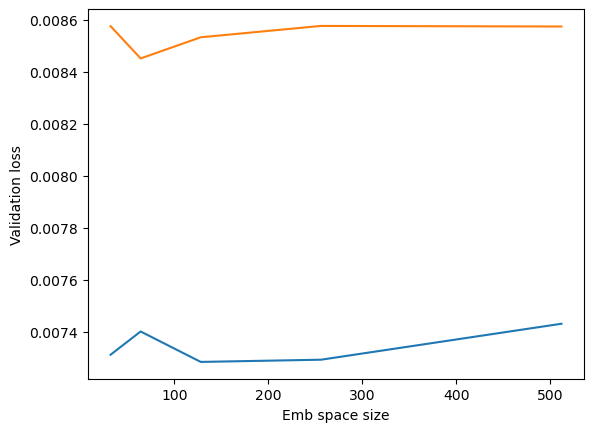

In [25]:
import matplotlib.pyplot as plt
for measure in measures_preproc_minmax:
    plt.plot(emb_spaces, measure)
plt.xlabel("Emb space size")
plt.ylabel("Validation loss")
plt.show()